# Word embedding

This notebook shows how to use PyMDE to create word embeddings in a few lines of code.

We will embed the 5000 most popular academic interests listed in Google Scholar.

In [1]:
import pymde

import numpy as np
import matplotlib.pyplot as plt
import torch


np.random.seed(0)
torch.manual_seed(0)

## Cooccurrence matrix

The data is a **cooccurrence matrix**, which counts the number of times each pair of interests cooccurred in a researchers Google Scholar profile page.

The ith row (and column) of the matrix corresponds to the ith interest (i.e., `interests[i]`)

In [2]:
dataset = pymde.datasets.google_scholar_interests()

cooccurrence_graph = dataset.data
interests = dataset.attributes['interests']

Apr 24 08:39:35 AM: Loading cached dataset.


We can visualize the cooccurrence matrix. No patterns are immediately discernible.

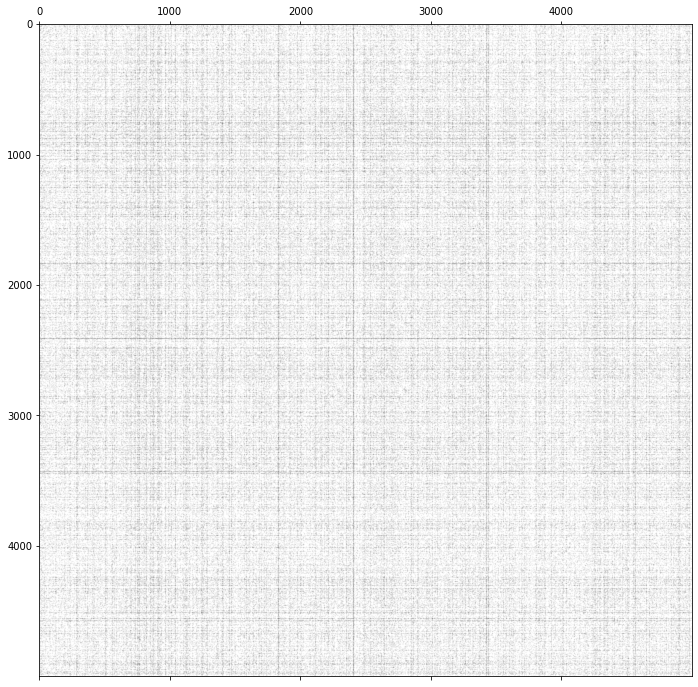

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.spy(cooccurrence_graph.A, ms=1e-2, color='k')
plt.show()

As a first cut, we will embed the words into $\mathbf{R}^1$, using PCA.

In [4]:
pca_embedding = pymde.pca(cooccurrence_graph.A.todense(), 1)
pca_embedding

tensor([[ 0.1020],
        [ 0.0918],
        [-0.2554],
        ...,
        [ 0.0996],
        [ 0.1021],
        [ 0.0624]])

We can visualize the PCA embedding by sorting the cooccurrence matrix according to the indices that sort the PCA embedding. Notice that this reveals some interesting structure.

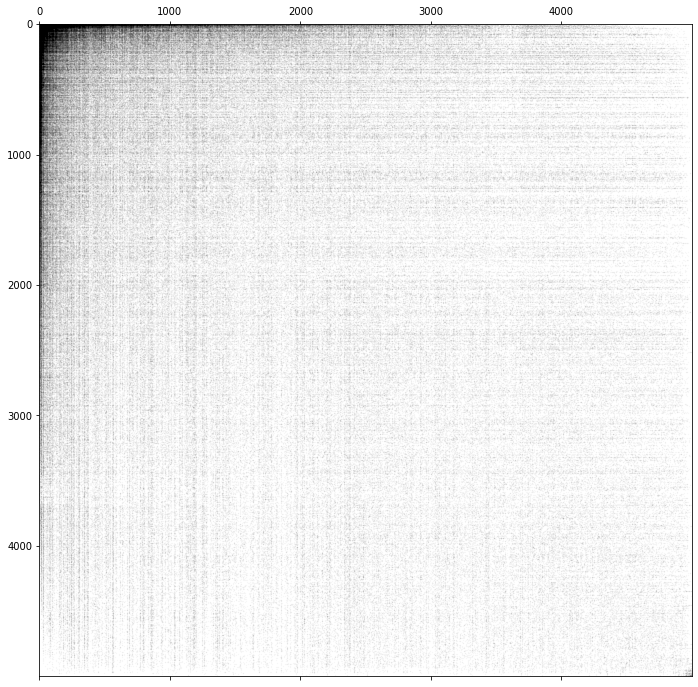

In [5]:
sort_indices = pca_embedding.flatten().sort().indices.numpy()
A_sorted = cooccurrence_graph.A[sort_indices][:, sort_indices]

plt.figure(figsize=(12, 12))
plt.spy(A_sorted, ms=1e-2, color='k')
plt.show()

Here are the first 20 entries in the sorted cooccurrence matrix. We can see that theey are mostly about artificial intelligence and biology, meaning that our simple embedding has uncovered that these topics are related.

In [6]:
list(np.array(interests)[sort_indices])[:20]

['machine learning',
 'computer vision',
 'artificial intelligence',
 'deep learning',
 'natural language processing',
 'robotics',
 'data mining',
 'image processing',
 'pattern recognition',
 'data science',
 'signal processing',
 'optimization',
 'bioinformatics',
 'reinforcement learning',
 'statistics',
 'information retrieval',
 'computational biology',
 'computer graphics',
 'big data',
 'medical imaging']

## Embedding

Now we will construct a more sophisticated embedding. We start by converting the counts into dissimilarity scores,
then compute a shortest path metric with respect to these scores.

In [7]:
dissimilarities = 1. / torch.log(cooccurrence_graph.weights)
dissimilarity_graph = pymde.Graph.from_edges(cooccurrence_graph.edges, dissimilarities)
plt.show()

In [8]:
shortest_path_graph = pymde.preprocess.graph.shortest_paths(dissimilarity_graph, verbose=True, n_workers=6)
plt.show()

Apr 24 08:39:56 AM: Computing shortest path distances (retaining 100.00 percent with max_distance=None) ...
Apr 24 08:39:56 AM: Graph is weighted ... using slow path.
Apr 24 08:39:57 AM: processed node 1/5000
Apr 24 08:39:58 AM: processed node 501/5000
Apr 24 08:40:00 AM: processed node 1001/5000
Apr 24 08:40:02 AM: processed node 1501/5000
Apr 24 08:40:03 AM: processed node 2001/5000
Apr 24 08:40:05 AM: processed node 2501/5000
Apr 24 08:40:07 AM: processed node 3001/5000
Apr 24 08:40:09 AM: processed node 3501/5000
Apr 24 08:40:10 AM: processed node 4001/5000
Apr 24 08:40:12 AM: processed node 4501/5000


In [9]:
!pip install plotly
import plotly.graph_objects as go


def interactive(X):
    if isinstance(X, torch.Tensor):
        X = X.cpu().numpy()
    fig = go.Figure(data=go.Scatter(x=X[:, 0],
                                    y=X[:, 1],
                                    marker_size=2.,
                                    mode='markers',
                                    text=interests))
    fig.show()

Finally we compute an embedding that preserves neighbors under the shortest path metric.

In [10]:
mde = pymde.preserve_neighbors(shortest_path_graph, verbose=True)

Apr 24 08:40:16 AM: Computing 15-nearest neighbors, with max_distance=3.330068349838257
Apr 24 08:40:18 AM: Computing quadratic initialization.


In [11]:
X = mde.embed(verbose=True)

Apr 24 08:40:18 AM: Fitting a centered embedding into R^2, for a graph with 5000 items and 134425 edges.
Apr 24 08:40:18 AM: `embed` method parameters: eps=1.0e-05, max_iter=300, memory_size=10
Apr 24 08:40:18 AM: iteration 000 | distortion 0.362266 | residual norm 0.582177 | step length 0.259351 | percent change 0.150988
Apr 24 08:40:18 AM: iteration 030 | distortion 0.294026 | residual norm 0.00129582 | step length 1 | percent change 0.832151
Apr 24 08:40:19 AM: iteration 060 | distortion 0.290134 | residual norm 0.000599459 | step length 1 | percent change 0.641361
Apr 24 08:40:19 AM: iteration 090 | distortion 0.289087 | residual norm 0.000710077 | step length 1 | percent change 0.144511
Apr 24 08:40:19 AM: iteration 120 | distortion 0.288715 | residual norm 0.000294239 | step length 1 | percent change 0.415768
Apr 24 08:40:20 AM: iteration 150 | distortion 0.288496 | residual norm 0.000161824 | step length 1 | percent change 0.215791
Apr 24 08:40:20 AM: iteration 180 | distortion 

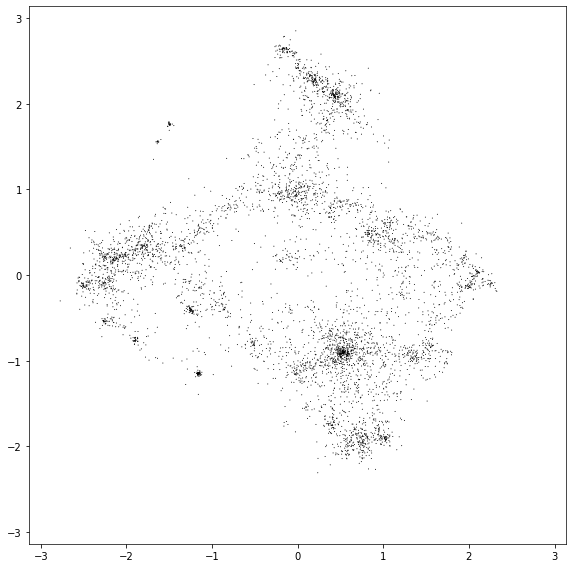

In [12]:
mde.plot(colors=['black'])
plt.show()

Try mousing over this embedding, to reveal the interest labels for each node. You'll find that the embedding has done a good job of clustering similar interests together.

In [13]:
interactive(X)